In [54]:
import numpy as np
import matplotlib.pyplot as plt

#コミットしてみた
#PIYO
#コンフリクトおきないかな？？？
#F

class Kernel:
    def __init__(self,param,bound=None):
        self.param = np.array(param)
        if(bound==None):
            bound = np.zeros([len(param),2])
            bound[:,1] = np.inf
        self.bound = np.array(bound)

    def __call__(self,x1,x2) -> float:
        """ ガウスカーネルを計算する。
            k(x1, x2) = a1*exp(-s*|x - x2|^2)

        Args:
            x1 (np.array)   : 入力値1
            x2 (np.array)   : 入力値2
            param (np.array): ガウスカーネルのパラメータ

        Returns:
            float: ガウスカーネルの値
        
        """
        a1,s,a2 = self.param
        return a1**2*np.exp(-0.5*((x1-x2)/s)**2) + a2**2*(x1==x2)

class GausskateiWithMyTheory():
    def __init__(self,kernel, N, name, weight, xd, yd, param_for_event):
        self.N = N
        self.name = name

        self.kernel = kernel
        self.theta = self.kernel.param
        self.rec_Hp = np.zeros([self.N, 3])
        self.Hp_send = np.zeros([self.N, 3])
        self.rec_Hp[name] = self.theta
        self.weight = weight
        self.xd, self.yd = xd, yd
        self.param_for_event = param_for_event

    def gakushuu(self,x0: np.array, y0: np.array):
        """カーネル行列: Kを計算する

        Args:
            x0 (np.array) : 既知のデータx0
            y0 (np.array) : 既知のデータy0
        """
        self.x0 = x0
        self.y0 = y0
        self.k00 = self.kernel(*np.meshgrid(x0,x0))
        self.k00_1 = np.linalg.inv(self.k00)

    def yosoku(self,x: np.array) -> np.array:
        """
        
        Args:
            k00_1 (np.array)    : K00の逆行列
            x0 (np.array)       : 既知のデータx0(N)
            x (np.array)        : 未知の入力データx(M)
            k10 (np.array)      : N×Mのカーネル行列
            k11 (np.array)      : M×Mのカーネル行列

        return:
            mu (np.array)       : 平均行列 (M×1)
            std (np.array)      : 標準偏差行列 (M×1) 
        """
        k00_1 = self.k00_1
        k01 = self.kernel(*np.meshgrid(self.x0,x,indexing='ij'))
        k10 = k01.T
        k11 = self.kernel(*np.meshgrid(x,x))

        mu = k10.dot(k00_1.dot(self.y0))
        sigma = k11 - k10.dot(k00_1.dot(k01))
        std = np.sqrt(sigma.diagonal())
        return mu,std

    def logyuudo(self,param=None): # 対数尤度
        if(param is None):
            k00 = self.k00
            k00_1 = self.k00_1
        else:
            self.kernel.param = param
            k00 = self.kernel(*np.meshgrid(self.x0,self.x0))
            k00_1 = np.linalg.inv(k00)
        return -(np.linalg.slogdet(k00)[1]+self.y0.dot(k00_1.dot(self.y0)))

    def kgrad (self, xi: np.array ,xj: np.array ,d) -> float:
        """アルゴリズムに必要な勾配

        Args:
            d (int)     : thetaの次元

        return:
            勾配 (int)  : 勾配
        """
        theta = self.kernel.param
        if d == 0:   
            return 2*theta[0]*np.exp(-0.5*theta[1]*np.linalg.norm(xi-xj)**2)
        elif d == 1:
            return theta[0]**2*np.exp(-0.5*(np.linalg.norm(xi-xj)/theta[1])**2)*(-(np.linalg.norm(xi-xj)/theta[1]))*(-np.linalg.norm(xi-xj)/theta[1]**2)
        elif d == 2:
            return (xj==xi)
        
    def kernel_matrix_grad(self, xd: np.array) -> np.array:
        self.grad_K = np.zeros((len(xd), len(xd), 3))
        
        for i in range(len(xd)):
            for j in range(len(xd)):
                for q in range(3):
                    self.grad_K[i][j][q] = self.kgrad(xd[i], xd[j], q)
    
    def grad_optim(self, xd: np.array, y: np.array, rou=10) -> np.array: 
        KD_00 = self.kernel(*np.meshgrid(xd,xd))
        KD_00_1 = np.linalg.inv(KD_00)

        self.kernel_matrix_grad(xd)
        
        self.grad = np.zeros(3)

        for d in range(3):
            if self.kernel.param[d] <= self.kernel.bound[d][0]:
                self.grad[d] = np.trace(KD_00_1 @ self.grad_K[:,:,d]) - (KD_00_1 @ y).T @ self.grad_K[:,:,d] @ (KD_00_1 @ y) + rou/self.N*2*(self.kernel.param[d]-self.kernel.bound[d][0])
            elif self.kernel.bound[d][0] < self.kernel.param[d] < self.kernel.bound[d][1]:
                self.grad[d] = np.trace(KD_00_1 @ self.grad_K[:,:,d]) - (KD_00_1 @ y).T @ self.grad_K[:,:,d] @ (KD_00_1 @ y)
            elif self.kernel.bound[d][1] <= self.kernel.param[d]:
                print(self.kernel.param, self.name)
                self.grad[d] = np.trace(KD_00_1 @ self.grad_K[:,:,d]) - (KD_00_1 @ y).T @ self.grad_K[:,:,d] @ (KD_00_1 @ y) + rou/self.N*2*(self.kernel.param[d]-self.kernel.bound[d][1])


    def saitekika(self, t): # パラメータを調整して学習
        """ハイパーパラメータの最適化
        x_i(t+1) = x_i(t) + Σp_ij(x_ji(t)-x_ij(t)) - a(t)∇f_i(x_i(t))

        Args:
            xD (np.array)       : エージェントiに与えられるデータセット
            y (np.array)        : エージェントiに与えられるデータセット
            param (np.array)    : パラメータ
            stepsize (float)    : ステップサイズ関数
            grad_f (np.array)   : 勾配(3×1)
            theta (np.array)    : Θ(3×1)

        Return:
            next_theta (np.array)   : optimization_theta (3×1)
        """
        self.theta = self.kernel.param
        self.rec_Hp[self.name] = self.theta
        self.Hp_send[self.name] = self.theta
        self.diff = self.rec_Hp - self.Hp_send #3×3の行列となるはず
        self.grad_optim(self.xd, self.yd)

        for i in range(3):
            self.theta[i] = self.theta[i] + np.dot(self.weight[i], self.diff[:,i]) - 0.01/(t+1)*self.grad[i]

        self.Hp_send[self.name] = self.theta
        self.rec_Hp[self.name] = self.theta

        self.kernel.param = self.theta
    
    def stepsize(self, t, step) -> float:
        return step / (t+1)
    
    def receive(self, state, name):
        """エージェントiからエージェントjの情報を受け取る
        Args:
            name : 送信してきたエージェント
            rec_Hp (np.array) : 近傍エージェントから受け取ったパラメータ
        """
        
        self.rec_Hp[name] = state
    
    def send(self, j):
        """エージェントiからエージェントjの情報を送信する
        Args:
            i : 送信するエージェント
            j : 受信するエージェント
            Hp : ハイパーパラメータ
        """
        self.Hp_send[j] = self.theta
        return self.Hp_send[j]

    def event_trigger(self, t, param_for_event):
        return param_for_event/ (t)

class Gausskatei:
    def __init__(self,kernel):
        self.kernel = kernel

    def gakushuu(self,x0: np.array, y0: np.array):
        """カーネル行列: Kを計算する

        Args:
            x0 (np.array) : 既知のデータx0
            y0 (np.array) : 既知のデータy0
        """
        self.x0 = x0
        self.y0 = y0
        self.k00 = self.kernel(*np.meshgrid(x0,x0))
        self.k00_1 = np.linalg.inv(self.k00)

    def yosoku(self,x: np.array) -> np.array:
        """
        
        Args:
            k00_1 (np.array)    : K00の逆行列
            x0 (np.array)       : 既知のデータx0(N)
            x (np.array)        : 未知の入力データx(M)
            k10 (np.array)      : N×Mのカーネル行列
            k11 (np.array)      : M×Mのカーネル行列

        return:
            mu (np.array)       : 平均行列 (M×1)
            std (np.array)      : 標準偏差行列 (M×1) 
        """
        k00_1 = self.k00_1
        k01 = self.kernel(*np.meshgrid(self.x0,x,indexing='ij'))
        k10 = k01.T
        k11 = self.kernel(*np.meshgrid(x,x))

        mu = k10.dot(k00_1.dot(self.y0))
        sigma = k11 - k10.dot(k00_1.dot(k01))
        std = np.sqrt(sigma.diagonal())
        return mu,std

    def logyuudo(self,param=None): # 対数尤度
        if(param is None):
            k00 = self.k00
            k00_1 = self.k00_1
        else:
            self.kernel.param = param
            k00 = self.kernel(*np.meshgrid(self.x0,self.x0))
            k00_1 = np.linalg.inv(k00)
        return -(np.linalg.slogdet(k00)[1]+self.y0.dot(k00_1.dot(self.y0)))

    def kgrad (self, xi: np.array ,xj: np.array ,d) -> float:
        """アルゴリズムに必要な勾配

        Args:
            d (int)     : thetaの次元

        return:
            勾配 (int)  : 勾配
        """
        theta = self.kernel.param
        if d == 0:
            return 2*theta[0]*np.exp(-0.5*theta[1]*np.linalg.norm(xi-xj)**2)
        elif d == 1:
            return theta[0]**2*np.exp(-0.5*(np.linalg.norm(xi-xj)/theta[1])**2)*(-(np.linalg.norm(xi-xj)/theta[1]))*(-np.linalg.norm(xi-xj)/theta[1]**2)
        elif d == 2:
            return (xj==xi)

    def kernel_matrix_grad(self, xd: np.array) -> np.array:
        self.grad_K = np.zeros((len(xd), len(xd), 3))
        
        for i in range(len(xd)):
            for j in range(len(xd)):
                for q in range(3):
                    self.grad_K[i][j][q] = self.kgrad(xd[i], xd[j], q)
    
    def grad_optim(self, xd: np.array, y: np.array) -> np.array: 
        KD_00 = self.kernel(*np.meshgrid(xd,xd))
        KD_00_1 = np.linalg.inv(KD_00)

        self.kernel_matrix_grad(xd)
        
        self.grad = np.zeros(3)

        for d in range(3):
            self.grad[d] = np.trace(KD_00_1 @ self.grad_K[:,:,d]) - (KD_00_1 @ y).T @ self.grad_K[:,:,d] @ (KD_00_1 @ y)

    def saitekika(self,xd: np.array, y: np.array, kurikaeshi=1000): # パラメータを調整して学習
        """ハイパーパラメータの最適化
        x_i(t+1) = x_i(t) + Σp_ij(x_ji(t)-x_ij(t)) - a(t)∇f_i(x_i(t))

        Args:
            xD (np.array)       : エージェントiに与えられるデータセット
            y (np.array)        : エージェントiに与えられるデータセット
            param (np.array)    : パラメータ
            stepsize (float)    : ステップサイズ関数
            grad_f (np.array)   : 勾配(3×1)
            theta (np.array)    : Θ(3×1)

        Return:
            next_theta (np.array)   : optimization_theta (3×1)
        """

        self.theta = self.kernel.param

        for t in range(kurikaeshi):
            self.grad_optim(xd, y)
            self.theta = self.theta - (0.01/(t+1))*self.grad

        self.kernel.param = self.theta
        self.k00 = self.kernel(*np.meshgrid(self.x0,self.x0))
        self.k00_1 = np.linalg.inv(self.k00)

E= 0
0回目


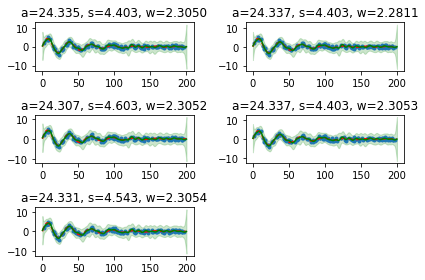

E= 10
0回目


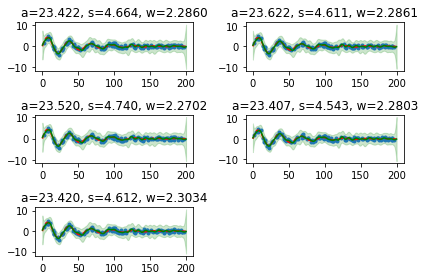

E= 50
0回目


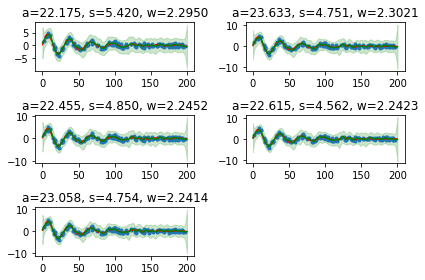

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LN
import networkx as nx
import copy

%matplotlib inline

#Parameters
#Number of agents
N = 5

#Number of dimensions of the decision variable
n = 5

#Coefficient of decision of stepsize : a(t) = a / t
stepsize = 0.08

# Coefficient of the edge weight  w_if = wc / max_degree
wc = 0.6

#Number of iterations
iteration = 30

#Coefficient of decision of stepsize : E_ij(t) = E(t) = eventtrigger / (t+1)
eventtrigger = [0, 10, 50]

# Randomization seed
np.random.seed(9)

#======================================================================#
#Communication Graph
A = np.array(
[[1, 1, 0, 1, 1],
 [1, 1, 0, 1, 0],
 [0, 0, 1, 1, 1],
 [1, 1, 1, 1, 0],
 [1, 0, 1, 0, 1]
 ])

G = nx.from_numpy_matrix(A)

# Weighted Stochastic Matrix P
a = np.zeros(N)

for i in range(N):
    a[i] = copy.copy(wc / nx.degree(G)[i])

P = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        if i != j and A[i][j] == 1:
            a_ij = min(a[i], a[j])
            P[i][j] = copy.copy(a_ij)
            P[j][i] = copy.copy(a_ij)

for i in range(N):
    sum = 0.0
    for j in range(N):
        sum += P[i][j]
    P[i][i] = 1.0 - sum
#======================================================================#
def y(x): # 実際の関数
    return 5*np.sin(np.pi/15*x)*np.exp(-x/50)

find_n = 150 # 既知の点の数
x0 = np.random.uniform(0,200,find_n) # 既知の点
y0 = y(x0) + np.random.normal(0,0.5,find_n)
param0 = [[11.5,15.2,0.3],[14.3,1.8,0.6],[1.2,13.2,1.7],[10.8,8.3,0.2],[7.4,9.3,3]] # パラメータの初期値
#param0 =[[1.5,0.4,2.7],[2.3,1.8,1.3],[3.2,1.2,0.7]]
# [[1.5,0.4,2.7],[2.3,2.8,1.3],[3.2,1.2,1.7]]
# [[1.5,3.4,2.7],[2.3,2.8,1.3],[3.2,1.2,1.7]] これいい！！
"""
0に関して，制約をつけないとリプシッツ連続性を言えなくなるため，
boundにて，制約をつけペナルティ関数法を用いてアルゴリズムの実装を行う．
"""
bound = [[1e-2,1e2],[1e-2,1e2],[1e-2,1e2]] # 下限上限
#kernel = Kernel(param0[0],bound)

x1 = np.linspace(0,200,400) #予測用のデータ

# alone_gp = Gausskatei(kernel) 
# alone_gp.gakushuu(x0,y0)

# for i in [0,1]:
#     if(i):
#         alone_gp.saitekika(xgit p0,y0,1000) # パラメータを調整する
#     plt.subplot(211+i)
#     plt.plot(x0,y0,'. ')
#     mu,std = alone_gp.yosoku(x1)
#     plt.plot(x1,y(x1),'--r')
#     plt.plot(x1,mu,'g')
#     plt.fill_between(x1,mu-std,mu+std,alpha=0.2,color='g')
#     plt.title('a=%.3f, s=%.3f, w=%.3f'%tuple(alone_gp.kernel.param))
# plt.tight_layout()
# plt.show()

xd = []
yd = []

for i in range(N):
    tmp_xd = np.random.uniform(0,200,30)
    xd.append(tmp_xd)
    yd.append(y(tmp_xd)+np.random.normal(0,0.5,30))

gp = []
multi_kernel = []
for i in range(N):
    multi_kernel.append(Kernel(param0[i], bound))
for i in range(N):
    gp.append(GausskateiWithMyTheory(multi_kernel[i], N, i, P, xd[i], yd[i], eventtrigger))
    gp[i].gakushuu(x0, y0)

normalize_error = [[],[],[]]

tmp_normalize_error = [0] * N

for q in range(N):
    mu,std = gp[q].yosoku(x1)
    seikai = y(x1)
    for j in range(len(x1)):
        tmp_normalize_error[q] += np.abs(mu[j] - seikai[j])**2   

initial_error = 0
for q in range(N):
    initial_error += tmp_normalize_error[q]

#勾配の変化を示すarray
#gradient_array = [0]*range(eventtrigger)

terminal_count = [[],[],[]]

for i in [0,1]:
    multi_gp = copy.deepcopy(gp)

    if (i):
        for e in range(len(eventtrigger)):
            count = 0

            print('E=', str(multi_gp[0].param_for_event[e]))
            #初期時刻での情報交換
            for i in range(N):
                for j in range(N):
                    if i!=j and A[i][j]==1:
                        multi_gp[j].receive(multi_gp[i].send(j),i)
                multi_gp[i].Hp_send[i] = multi_gp[i].theta

            for t in range(iteration):

                if t==0:
                    normalize_error[e].append(initial_error)

                if (t%100)==0:            
                    print(str(t) + '回目')
                for i in range(N):
                    for j in range(N):
                        if i!=j and A[i][j]==1:
                            if LN.norm(multi_gp[i].kernel.param-multi_gp[i].Hp_send[j], ord=1) > multi_gp[i].event_trigger(t+1, multi_gp[i].param_for_event[e]):
                                count += 1

                                multi_gp[j].receive(multi_gp[i].send(j), i)

                for i in range(N):
                    multi_gp[i].saitekika(t+1)

                tmp_normalize_error = [0]*N
                sum_normalize_error = 0
                
                for q in range(N):
                    multi_gp[q].gakushuu(x0,y0)
                    mu,std = multi_gp[q].yosoku(x1)
                    seikai = y(x1)
                    for j in range(len(x1)):
                        tmp_normalize_error[q] += np.abs(mu[j] - seikai[j])**2   
                    sum_normalize_error += tmp_normalize_error[q]
                
                normalize_error[e].append(sum_normalize_error)
            
            terminal_count[e] = count

            for d in range(N):
                multi_gp[d].gakushuu(x0,y0)
                plt.subplot(321+d)
                plt.plot(x0,y0,'. ')
                mu,std = multi_gp[d].yosoku(x1)
                plt.plot(x1,y(x1),'--r')
                plt.plot(x1,mu,'g')
                plt.fill_between(x1,mu-std,mu+std,alpha=0.2,color='g')
                plt.title('a=%.3f, s=%.3f, w=%.3f'%tuple(multi_gp[d].kernel.param) + str(multi_gp[d].name))
                plt.tight_layout()

            plt.show()    


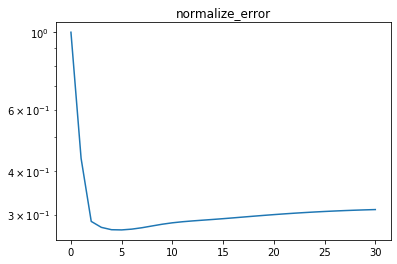

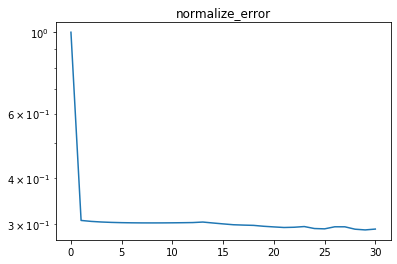

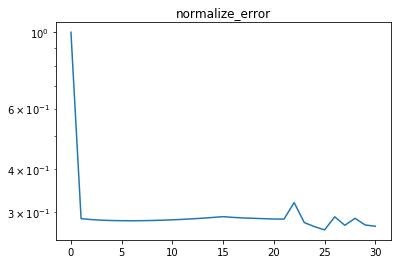

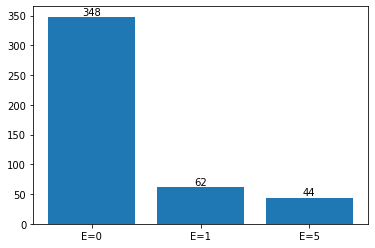

In [52]:
for e in range(len(eventtrigger)):
    plt.title('normalize_error')
    plt.plot(np.arange(0,iteration+1), np.array(normalize_error[e])/initial_error)
    plt.yscale('log')

    plt.show()

label = ["E=0", "E=1", "E=5"]
left = [0,1,2]
color = ['g', 'b', 'r']

plt.bar(left, terminal_count, tick_label=label)

for x, y in  zip(left, terminal_count):
    plt.text(x, y, y, ha='center', va='bottom')

plt.show()
